In [1]:
from dataclasses import dataclass
from typing import Optional, Union, List
import numpy as np
import gym
import gym.spaces
import gym.envs.registration
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image, ImageDraw
import plotly.express as px


from w6d3 import utils
from w6d2.solutions import *

MAIN = __name__ == "__main__"

In [2]:
ObsType = int
ActType = int

class DiscreteEnviroGym(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete

    def __init__(self, env: Environment):
        super().__init__()
        self.env = env
        self.observation_space = gym.spaces.Discrete(env.num_states)
        self.action_space = gym.spaces.Discrete(env.num_actions)
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Samples from the underlying dynamics of the environment
        '''
        (states, rewards, probs) = self.env.dynamics(self.pos, action)
        idx = self.np_random.choice(len(states), p=probs)
        (new_state, reward) = (states[idx], rewards[idx])
        self.pos = new_state
        done = self.pos in self.env.terminal
        return (new_state, reward, done, {"env": self.env})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        self.pos = self.env.start
        return (self.pos, {"env": self.env}) if return_info else self.pos

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"

In [3]:
gym.envs.registration.register(
    id="NorvigGrid-v0",
    entry_point=DiscreteEnviroGym,
    max_episode_steps=100,
    nondeterministic=True,
    kwargs={"env": Norvig(penalty=-0.04)},
)

gym.envs.registration.register(
    id="ToyGym-v0", 
    entry_point=DiscreteEnviroGym, 
    max_episode_steps=2, 
    nondeterministic=False, 
    kwargs={"env": Toy()}
)

In [4]:
@dataclass
class Experience:
    '''A class for storing one piece of experience during an episode run'''
    obs: ObsType
    act: ActType
    reward: float
    new_obs: ObsType
    new_act: Optional[ActType] = None

@dataclass
class AgentConfig:
    '''Hyperparameters for agents'''
    epsilon: float = 0.1
    lr: float = 0.05
    optimism: float = 0

defaultConfig = AgentConfig()

class Agent:
    '''Base class for agents interacting with an environment (you do not need to add any implementation here)'''
    rng: np.random.Generator

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__

    def get_action(self, obs: ObsType) -> ActType:
        raise NotImplementedError()

    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

    def run_episode(self, seed) -> List[int]:
        '''
        Simulates one episode of interaction, agent learns as appropriate
        Inputs:
            seed : Seed for the random number generator
        Outputs:
            The rewards obtained during the episode
        '''
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        while not done:
            act = self.get_action(obs)
            (new_obs, reward, done, info) = self.env.step(act)
            exp = Experience(obs, act, reward, new_obs)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def train(self, n_runs=500):
        '''
        Run a batch of episodes, and return the total reward obtained per episode
        Inputs:
            n_runs : The number of episodes to simulate
        Outputs:
            The discounted sum of rewards obtained for each episode
        '''
        all_rewards = []
        for seed in trange(n_runs):
            rewards = self.run_episode(seed)
            all_rewards.append(utils.sum_rewards(rewards, self.gamma))
        return all_rewards

class Random(Agent):
    def get_action(self, obs: ObsType) -> ActType:
        return self.rng.integers(0, self.num_actions)

Cheater Agent:

100%|██████████| 100/100 [00:00<00:00, 14865.51it/s]


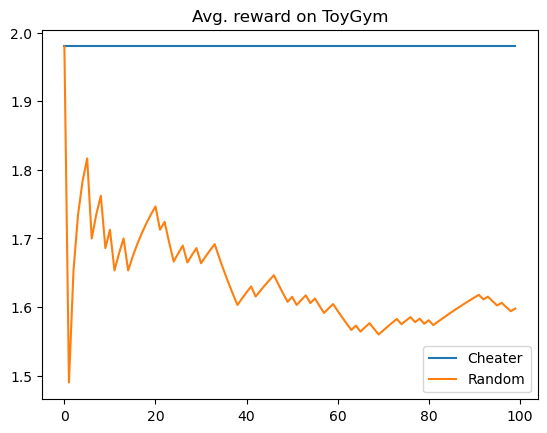

In [5]:
class Cheater(Agent):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma=0.99, seed=0):
        super().__init__(env, config, gamma, seed)
        self.pi = find_optimal_policy(env.unwrapped.env, gamma)

    def get_action(self, obs):
        return self.pi[obs]


if MAIN:
    env_toy = gym.make("ToyGym-v0")
    agents_toy = [Cheater(env_toy), Random(env_toy)]
    for agent in agents_toy:
        returns = agent.train(n_runs=100)
        plt.plot(utils.cummean(returns), label=agent.name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()

SARSA and Q-Learning

100%|██████████| 1000/1000 [00:00<00:00, 1013.50it/s]


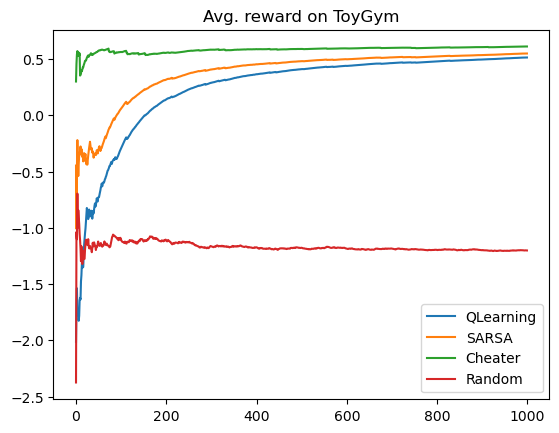

In [6]:
class EpsilonGreedy(Agent):
    '''
    A class for SARSA and Q-Learning to inherit from.
    '''

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        super().__init__(env, config, gamma, seed)
        self.Q = np.ones((env.observation_space.n, env.action_space.n)) * config.optimism
        
        


    def get_action(self, obs: ObsType) -> ActType:
        if self.rng.uniform() < self.config.epsilon:
            return self.rng.integers(self.env.action_space.n)
        else:
            return np.argmax(self.Q[obs])

class QLearning(EpsilonGreedy):      
    def observe(self, exp: Experience) -> None:
        s, a, r, new_s = exp.obs, exp.act, exp.reward, exp.new_obs
        self.Q[s][a] += self.config.lr * (r + self.gamma * np.max(self.Q[new_s]) - self.Q[s][a])
        
class SARSA(EpsilonGreedy):    
    def observe(self, exp: Experience) -> None:
        s, a, r, new_s, new_a = exp.obs, exp.act, exp.reward, exp.new_obs, exp.new_act
        self.Q[s][a] += self.config.lr * (r + self.gamma * self.Q[new_s][new_a] - self.Q[s][a])

    def run_episode(self, seed) -> List[int]:
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        act = self.get_action(obs)
        while not done:
            (new_obs, reward, done, info) = self.env.step(act)
            new_act = self.get_action(new_obs)
            exp = Experience(obs, act, reward, new_obs, new_act)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
            act = new_act
        return rewards


if MAIN:
    env_norvig = gym.make("NorvigGrid-v0")
    # "TODO: (ignored) Init config_norvig using the AgentConfig class" 
    n_runs = 1000
    gamma = 0.99
    seed = 1
    args_nor = (env_norvig, defaultConfig, gamma, seed)
    agents_norvig = [QLearning(*args_nor), SARSA(*args_nor), Cheater(*args_nor), Random(*args_nor)] 
    returns_norvig = {}
    for agent in agents_norvig:
        returns_norvig[agent.name] = agent.train(n_runs)
if MAIN:
    for agent in agents_norvig:
        name = agent.name
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()

## Working with CliffWakler

In [7]:
def show_cliff_value(Q: Arr, title: Optional[str] = None):
    '''
    Displays the value of each state in CliffWalking-v0 given a Q-value table.
    '''
    V = Q.max(axis=-1).reshape(4, 12)
    fig = px.imshow(V, text_auto=".2f", title=title)
    fig.show()

def show_cliff_policy(Q: Arr):
    '''
    Displays the greedy policy for CliffWalking-v0 given a Q-value table.
    '''
    pi = Q.argmax(axis=-1).reshape((4, 12))
    objects = {(3, 0): "green", (3, 11): "red"} | {(3, i): "black" for i in range(1, 11)}
    img = Image.new(mode="RGB", size=(1200, 400), color="white")
    draw = ImageDraw.Draw(img)
    for x in range(0, img.width+1, 100):
        draw.line([(x, 0), (x, img.height)], fill="black", width=4)
    for y in range(0, img.height+1, 100):
        draw.line([(0, y), (img.width, y)], fill="black", width=4)
    for x in range(12):
        for y in range(4):
            draw.regular_polygon((50+x*100, 50+y*100, 20), 3, rotation=-int(90*pi[y][x]), fill="black")
            if (y, x) in objects:
                draw.regular_polygon((50+x*100, 50+y*100, 40), 4, fill=objects[(y, x)])
    display(img.resize((600, 200)))

In [8]:
if MAIN:
    env_cliff = gym.make("CliffWalking-v0")
    "TODO: Init config_norvig using the AgentConfig class"
    cliffConfig = AgentConfig(0.05, 0.1, 0)
    n_runs = 1000
    gamma = 1
    seed = 1
    args_cliff = (env_cliff, cliffConfig, gamma, seed)
    agents_norvig = [QLearning(*args_cliff), SARSA(*args_cliff),Random(*args_cliff)] 
    returns_norvig = {}
    for agent in agents_norvig:
        returns_norvig[agent.name] = agent.train(n_runs)

100%|██████████| 1000/1000 [00:34<00:00, 29.39it/s]


## Q-Learning vs SARSA LEARNING
The top is the Policy Developed from Q-Learning
The bottom is the Policy Developed from SARSA

Note how the SARSA is being more cautious. Why? When the Q-values are updated in the SARSA algorithm, it updates the Q value based off the Q value related to the actual next action the agent takes, not what the optimal choice should have been; as a result, it takes into account the epsilom-random choices that occur, and hence stays away from the edge! 

Q-learning updates Q-values based off the what an agent that followed the Q-values greedily would do, and thus kinda forgets that the agent moves randomly with epsilon probability. Hence, why Q-learning gets outperformed here


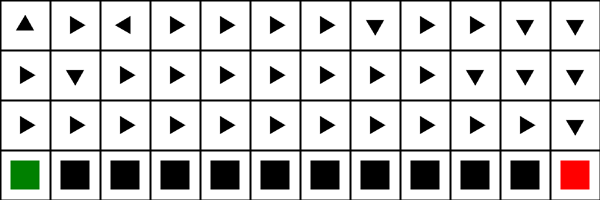

In [9]:
show_cliff_policy(agents_norvig[0].Q)

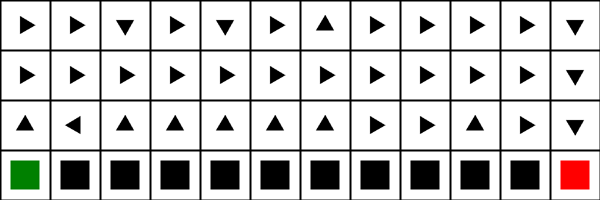

In [10]:
show_cliff_policy(agents_norvig[1].Q)

Example Q Values from Q-Learning

In [11]:
show_cliff_value(agents_norvig[0].Q)

/Users/codyrushing/mambaforge/envs/ARENAenv/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



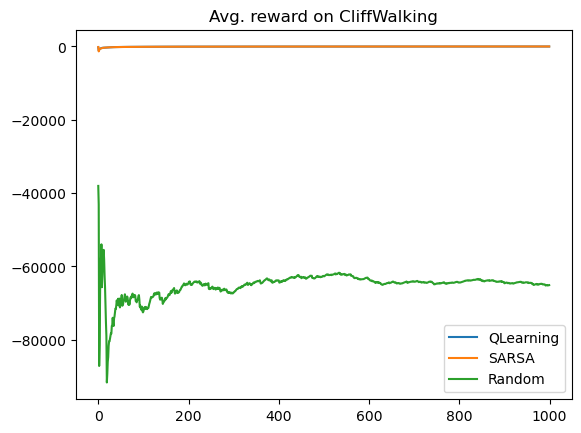

In [12]:
if MAIN:
    for agent in agents_norvig:
        name = agent.name
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on {env_cliff.spec.name}")
    plt.show()

Sorry. Let's zoom in a bit :)

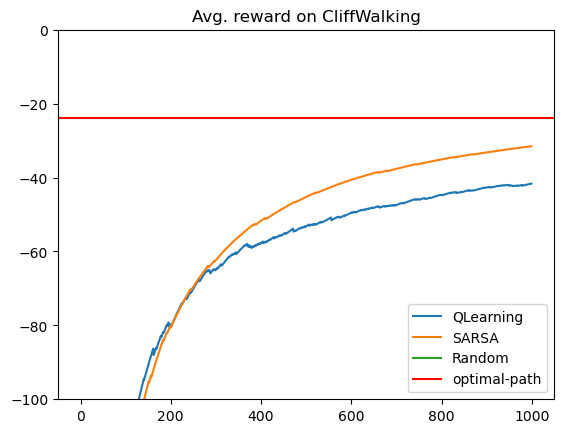

In [13]:
if MAIN:
    for agent in agents_norvig:
        name = agent.name
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.axhline(y=-24, color='r', linestyle='-', label="optimal-path") # i think it is 24?
    plt.legend()
    plt.title(f"Avg. reward on {env_cliff.spec.name}")
    plt.ylim(-100,0)
    plt.show()